In [1]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import joblib
import os
import random
import joblib
from typing import Tuple, Dict, List

In [3]:
traind=pd.read_csv('train.csv')
testd=pd.read_csv('test.csv')
df_train=traind.copy()
df_test=testd.copy()

In [4]:
#Cleaning
bool_cols = [
    'is_esc','is_adjustable_steering','is_tpms','is_parking_sensors','is_parking_camera',
    'is_front_fog_lights','is_rear_window_wiper','is_rear_window_washer','is_rear_window_defogger','is_brake_assist',
    'is_power_door_locks','is_central_locking','is_power_steering','is_driver_seat_height_adjustable',
    'is_day_night_rear_view_mirror','is_ecw','is_speed_alert'
]

for col in bool_cols:
    df_train[col] = df_train[col].map({'Yes': 1, 'No': 0})
    df_test[col]  = df_test[col].map({'Yes': 1, 'No': 0})


In [5]:
df_train=df_train.drop('policy_id', axis=1)


In [6]:
df_train['max_power_value']=df_train['max_power'].replace(r'([0-9.]+).*',r'\1',regex=True).astype(float)
df_train['max_power_rpm']=df_train['max_power'].replace(r'.*@([0-9]+).*',r'\1',regex=True).astype(float)
df_train['max_torque_value']=df_train['max_torque'].replace(r'([0-9.]+).*',r'\1',regex=True).astype(float)
df_train['max_torque_rpm']=df_train['max_torque'].replace(r'.*@([0-9]+).*',r'\1',regex=True).astype(float)
df_train.drop('max_torque', axis=1, inplace=True)
df_test.drop('max_torque', axis=1, inplace=True)
df_train.drop('max_power', axis=1, inplace=True)
df_test.drop('max_power', axis=1, inplace=True)

In [7]:
df_train.columns

Index(['policy_tenure', 'age_of_car', 'age_of_policyholder', 'area_cluster',
       'population_density', 'make', 'segment', 'model', 'fuel_type',
       'engine_type', 'airbags', 'is_esc', 'is_adjustable_steering', 'is_tpms',
       'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type',
       'displacement', 'cylinder', 'transmission_type', 'gear_box',
       'steering_type', 'turning_radius', 'length', 'width', 'height',
       'gross_weight', 'is_front_fog_lights', 'is_rear_window_wiper',
       'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
       'is_power_door_locks', 'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating', 'is_claim',
       'max_power_value', 'max_power_rpm', 'max_torque_value',
       'max_torque_rpm'],
      dtype='object')

In [8]:
#Display categories in area cluster
traind['steering_type'].value_counts()

,count
steering_type,
Power,33502
Electric,23881
Manual,1209


In [9]:
pd.set_option('display.max_columns', None)
df_train.head(5)

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,max_power_value,max_power_rpm,max_torque_value,max_torque_rpm
0,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,F8D Petrol Engine,2,0,0,0,1,0,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,40.36,6000.0,60.0,3500.0
1,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,F8D Petrol Engine,2,0,0,0,1,0,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,40.36,6000.0,60.0,3500.0
2,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,F8D Petrol Engine,2,0,0,0,1,0,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,40.36,6000.0,60.0,3500.0
3,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,1.2 L K12N Dualjet,2,1,1,0,1,1,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,1,0,0,1,1,1,1,1,1,1,1,1,2,0,88.50,6000.0,113.0,4400.0
4,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,1.0 SCe,2,0,0,0,0,1,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,0,0,0,0,0,1,1,1,0,1,1,1,2,0,67.06,5500.0,91.0,4250.0


In [10]:
#Age of policy hodler- display


In [11]:


other_cats = ['fuel_type','rear_brakes_type','transmission_type','steering_type','model', 'engine_type', 'segment', 'area_cluster']



encoders = {}

for col in other_cats:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    encoders[col] = le

joblib.dump(encoders, "all_encoders.pkl")



['all_encoders.pkl']

In [12]:
eps = 1e-6
def add_interactions(df):
    # power/torque vs weight
    if {'max_power_value','gross_weight'}.issubset(df.columns):
        df['power_to_weight'] = df['max_power_value'] / (df['gross_weight'] + eps)
    if {'max_torque_value','gross_weight'}.issubset(df.columns):
        df['torque_to_weight'] = df['max_torque_value'] / (df['gross_weight'] + eps)
    # car age vs policy tenure
    if {'age_of_car','policy_tenure'}.issubset(df.columns):
        df['car_age_ratio'] = df['age_of_car'] / (df['policy_tenure'] + 1.0)
    # engine "efficiency"
    if {'displacement','max_power_value'}.issubset(df.columns):
        df['engine_efficiency'] = df['displacement'] / (df['max_power_value'] + eps)
    return df

df_train = add_interactions(df_train)
df_test  = add_interactions(df_test)

In [13]:
df_train.head(5)

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,max_power_value,max_power_rpm,max_torque_value,max_torque_rpm,power_to_weight,torque_to_weight,car_age_ratio,engine_efficiency
0,0.515874,0.05,0.644231,0,4990,1,0,0,0,6,2,0,0,0,1,0,1,796,3,1,5,2,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,40.36,6000.0,60.0,3500.0,0.034059,0.050633,0.032984,19.722497
1,0.672619,0.02,0.375000,11,27003,1,0,0,0,6,2,0,0,0,1,0,1,796,3,1,5,2,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,40.36,6000.0,60.0,3500.0,0.034059,0.050633,0.011957,19.722497
2,0.841110,0.02,0.384615,15,4076,1,0,0,0,6,2,0,0,0,1,0,1,796,3,1,5,2,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,40.36,6000.0,60.0,3500.0,0.034059,0.050633,0.010863,19.722497
3,0.900277,0.11,0.432692,16,21622,1,3,3,2,2,2,1,1,0,1,1,1,1197,4,0,5,0,4.8,3995,1735,1515,1335,1,0,0,1,1,1,1,1,1,1,1,1,2,0,88.50,6000.0,113.0,4400.0,0.066292,0.084644,0.057886,13.525424
4,0.596403,0.11,0.634615,17,34738,2,0,4,2,0,2,0,0,0,0,1,1,999,3,0,5,0,5.0,3731,1579,1490,1155,0,0,0,0,0,1,1,1,0,1,1,1,2,0,67.06,5500.0,91.0,4250.0,0.058061,0.078788,0.068905,14.897107


In [14]:
#TRAIN
y = df_train['is_claim'].fillna(0).astype(int)
X = df_train.drop('is_claim', axis=1)

In [15]:
test_features = df_test.drop('policy_id', axis=1)
test_features = test_features.reindex(columns=X.columns, fill_value=0)

print("Train shape:", X.shape, " Test shape:", test_features.shape)


Train shape: (58592, 48)  Test shape: (39063, 48)


In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_aucs, xgb_aucs, cat_aucs = [], [], []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    pos_ratio = y_tr.value_counts()[0] / y_tr.value_counts()[1]

    # --- Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=16,
        min_samples_split=4,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_tr, y_tr)
    rf_probs = rf.predict_proba(X_val)[:, 1]
    rf_auc = roc_auc_score(y_val, rf_probs)
    rf_aucs.append(rf_auc)

    # --- XGBoost ---
    xgb_model = xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='auc',
        scale_pos_weight=pos_ratio,
        tree_method='hist',
        random_state=42
    )
    xgb_model.fit(X_tr, y_tr)
    xgb_probs = xgb_model.predict_proba(X_val)[:, 1]
    xgb_auc = roc_auc_score(y_val, xgb_probs)
    xgb_aucs.append(xgb_auc)

    # --- CatBoost ---
    cat = CatBoostClassifier(
        iterations=700,
        depth=8,
        learning_rate=0.05,
        loss_function='Logloss',
        eval_metric='AUC',
        class_weights=[1.0, pos_ratio],
        verbose=False,
        random_seed=42
    )
    cat.fit(X_tr, y_tr)
    cat_probs = cat.predict_proba(X_val)[:, 1]
    cat_auc = roc_auc_score(y_val, cat_probs)
    cat_aucs.append(cat_auc)

    print(f"Fold {fold}: RF AUC={rf_auc:.4f}, XGB AUC={xgb_auc:.4f}, CAT AUC={cat_auc:.4f}")

print("\nMean CV AUCs:")
print("RandomForest:", np.mean(rf_aucs))
print("XGBoost     :", np.mean(xgb_aucs))
print("CatBoost    :", np.mean(cat_aucs))

Fold 1: RF AUC=0.6122, XGB AUC=0.6202, CAT AUC=0.6175
Fold 2: RF AUC=0.6231, XGB AUC=0.6314, CAT AUC=0.6251
Fold 3: RF AUC=0.6383, XGB AUC=0.6367, CAT AUC=0.6408
Fold 4: RF AUC=0.6355, XGB AUC=0.6255, CAT AUC=0.6218
Fold 5: RF AUC=0.6152, XGB AUC=0.6174, CAT AUC=0.6155

Mean CV AUCs:
RandomForest: 0.6248507819918848
XGBoost     : 0.6262452715344937
CatBoost    : 0.6241528012512313


In [17]:
# 8. PICK BEST MODEL & TRAIN ON FULL DATA
# =========================
mean_scores = {
    'RandomForest': np.mean(rf_aucs),
    'XGBoost': np.mean(xgb_aucs),
    'CatBoost': np.mean(cat_aucs)
}
best_name = max(mean_scores, key=mean_scores.get)
print("\nBest model by mean CV AUC:", best_name, " -> ", mean_scores[best_name])

pos_ratio_full = y.value_counts()[0] / y.value_counts()[1]

if best_name == 'RandomForest':
    best_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=16,
        min_samples_split=4,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
elif best_name == 'XGBoost':
    best_model = xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='auc',
        scale_pos_weight=pos_ratio_full,
        tree_method='hist',
        random_state=42
    )
else:
    best_model = CatBoostClassifier(
        iterations=700,
        depth=8,
        learning_rate=0.05,
        loss_function='Logloss',
        eval_metric='AUC',
        class_weights=[1.0, pos_ratio_full],
        verbose=False,
        random_seed=42
    )

best_model.fit(X, y)

os.makedirs("models", exist_ok=True)

model_filename = f"best_model_{best_name}.pkl"
model_path = os.path.join("models", model_filename)

joblib.dump(best_model, model_path)

print(f"\nSaved best model to: {model_path}")
# (Optional) Inference on test:
# test_probs = best_model.predict_proba(test_features)[:, 1]
# submission = pd.DataFrame({'policy_id': test_policy_ids, 'is_claim': test_probs})
# submission.to_csv('submission.csv', index=False)



Best model by mean CV AUC: XGBoost  ->  0.6262452715344937

Saved best model to: models/best_model_XGBoost.pkl


In [18]:
X_tr.dtypes

,0
policy_tenure,float64
age_of_car,float64
age_of_policyholder,float64
area_cluster,int64
population_density,int64
make,int64
segment,int64
model,int64
fuel_type,int64
engine_type,int64


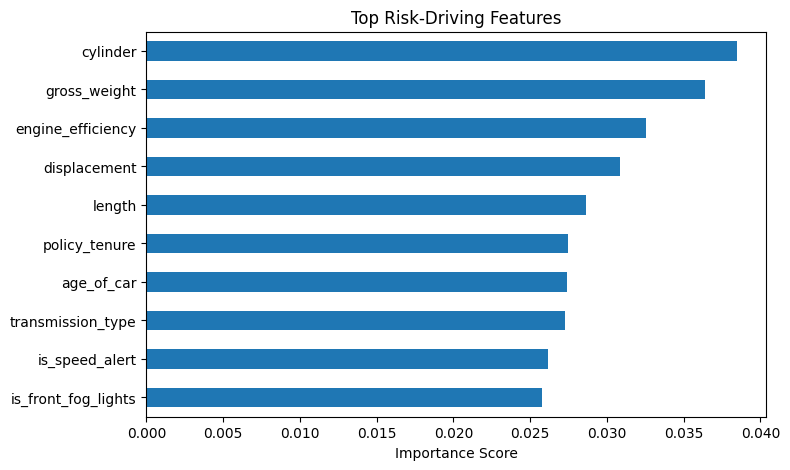

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
feat_imp.head(10).plot(kind="barh")
plt.xlabel("Importance Score")
plt.title("Top Risk-Driving Features")
plt.gca().invert_yaxis()
plt.show()



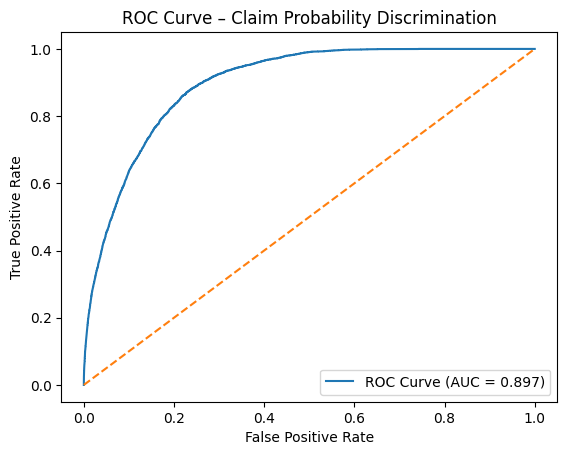

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_probs = best_model.predict_proba(X)[:, 1]

fpr, tpr, _ = roc_curve(y, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Claim Probability Discrimination")
plt.legend()
plt.show()


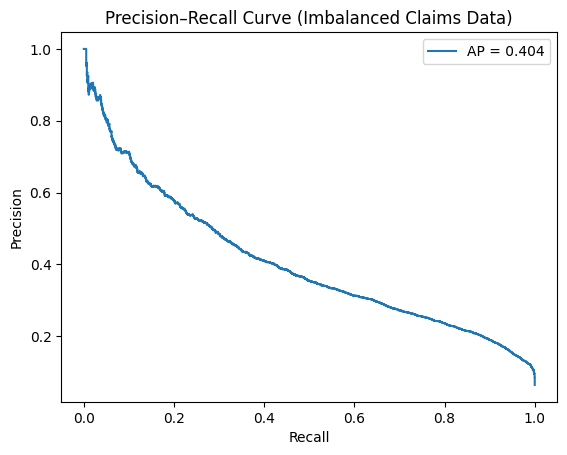

In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y, y_probs)
ap = average_precision_score(y, y_probs)

plt.figure()
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Imbalanced Claims Data)")
plt.legend()
plt.show()


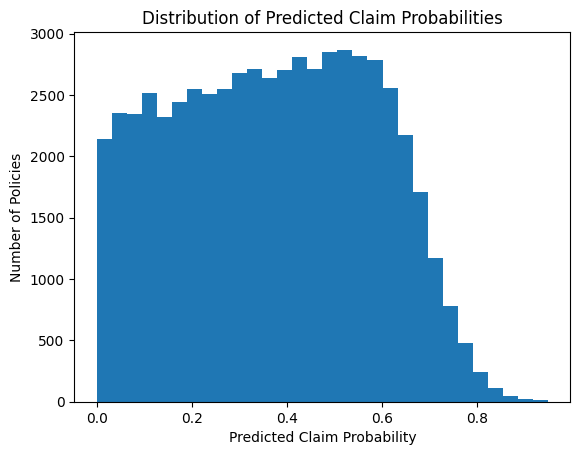

In [31]:
plt.figure()
plt.hist(y_probs, bins=30)
plt.xlabel("Predicted Claim Probability")
plt.ylabel("Number of Policies")
plt.title("Distribution of Predicted Claim Probabilities")
plt.show()


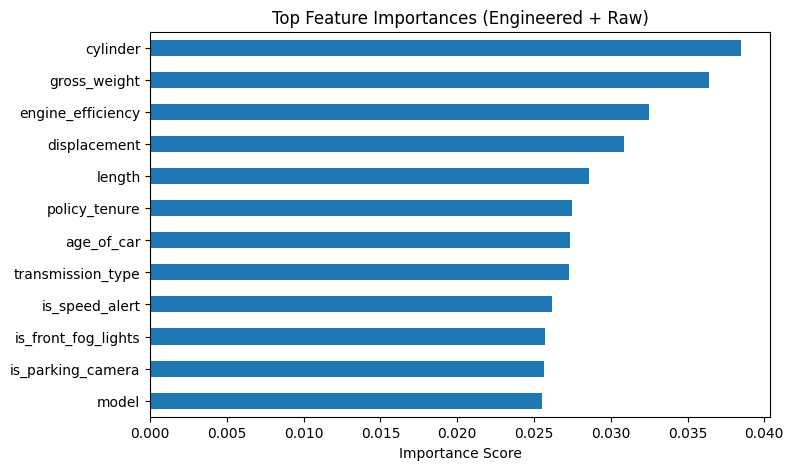

In [32]:
import pandas as pd

importances = best_model.feature_importances_
feat_imp = (
    pd.Series(importances, index=X.columns)
    .sort_values(ascending=False)
    .head(12)
)

plt.figure(figsize=(8, 5))
feat_imp.plot(kind="barh")
plt.xlabel("Importance Score")
plt.title("Top Feature Importances (Engineered + Raw)")
plt.gca().invert_yaxis()
plt.show()


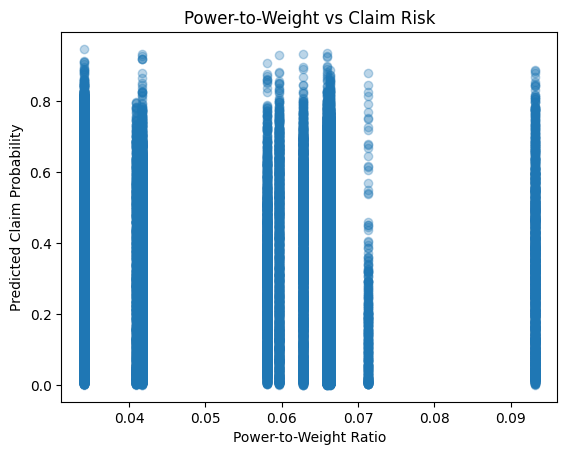

In [33]:
plt.figure()
plt.scatter(X["power_to_weight"], y_probs, alpha=0.3)
plt.xlabel("Power-to-Weight Ratio")
plt.ylabel("Predicted Claim Probability")
plt.title("Power-to-Weight vs Claim Risk")
plt.show()


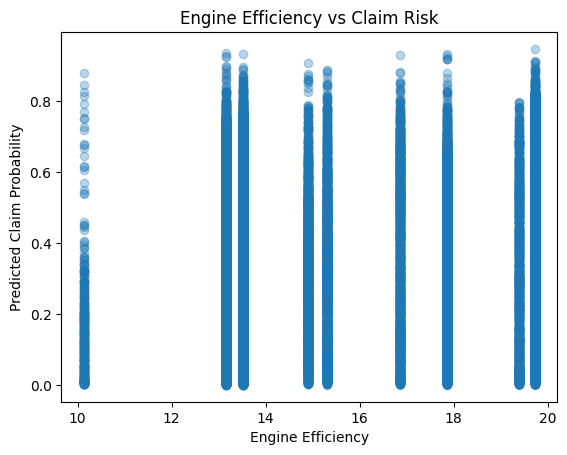

In [34]:
plt.figure()
plt.scatter(X["engine_efficiency"], y_probs, alpha=0.3)
plt.xlabel("Engine Efficiency")
plt.ylabel("Predicted Claim Probability")
plt.title("Engine Efficiency vs Claim Risk")
plt.show()


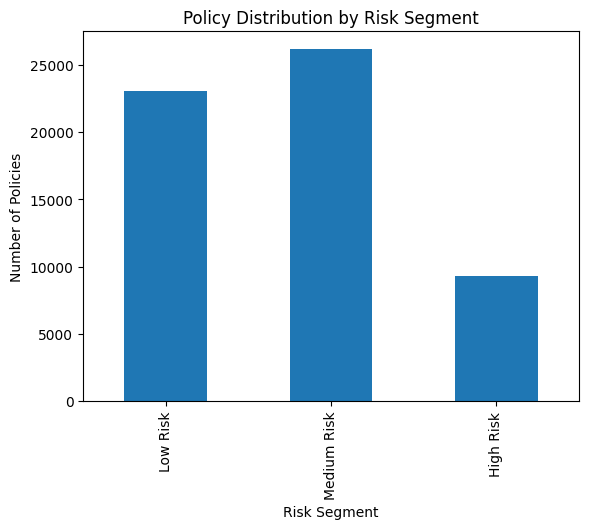

In [35]:
risk_segment = pd.cut(
    y_probs,
    bins=[0, 0.3, 0.6, 1.0],
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

risk_segment.value_counts().plot(kind="bar")
plt.xlabel("Risk Segment")
plt.ylabel("Number of Policies")
plt.title("Policy Distribution by Risk Segment")
plt.show()


In [19]:
!pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.3 MB/s eta 0:00:00


Load the submission, test and train files into runtime, and wait fdor the pkl files to be created by the code

also upload image to be accessed by streamlit

In [20]:
%%writefile app1.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import re

st.set_page_config(page_title="Car Insurance Claim Prediction", page_icon="🚗", layout="wide")
st.title("Car Insurance Claim Prediction")

st.sidebar.title("Navigation")
page = st.sidebar.radio('Go to', ['Home', 'Data Overview', 'Prediction'])

if page == 'Home':
    st.title("Introduction")
    st.markdown("This app predicts whether a car insurance policy will result in a claim.")

elif page == 'Data Overview':
    st.title('Data Overview')
    st.markdown("Data overview section is under construction.")

elif page == 'Prediction':
    st.title('Prediction')

    # Load model & encoders
    model = joblib.load('/content/models/best_model_XGBoost.pkl')
    encoders = joblib.load("/content/all_encoders.pkl")

    st.subheader("Categorical Fields")
    fuel_type = st.selectbox("Fuel Type", encoders['fuel_type'].classes_)
    rear_brakes_type = st.selectbox("Rear Brakes Type", encoders['rear_brakes_type'].classes_)
    transmission_type = st.selectbox("Transmission Type", encoders['transmission_type'].classes_)
    steering_type = st.selectbox("Steering Type", encoders['steering_type'].classes_)
    model_sel = st.selectbox("Model", encoders['model'].classes_)
    engine_type = st.selectbox("Engine Type", encoders['engine_type'].classes_)
    segment = st.selectbox("Segment", encoders['segment'].classes_)
    area_cluster = st.selectbox("Area Cluster", encoders['area_cluster'].classes_)

    st.subheader("Numeric Fields")
    numeric_cols = [
        "policy_tenure", "age_of_car", "age_of_policyholder", "population_density",
        "airbags", "displacement", "cylinder", "turning_radius", "length",
        "width", "height", "gross_weight", "ncap_rating", "gear_box","make"
    ]
    user_input = {}
    for col in numeric_cols:
        user_input[col] = st.number_input(col.replace("_", " ").title(), min_value=0.0)

    st.subheader("Torque & Power")
    user_input["max_power_value"] = st.number_input("Max Power Value (Integer) in bhp", placeholder="e.g., 60")
    user_input["max_torque_value"] = st.number_input("Max Torque Value (Integer) in Nm", placeholder="e.g., 60")
    user_input["max_power_rpm"] = st.number_input("Max Power RPM (Value) in rpm", placeholder="e.g., 3500")
    user_input["max_torque_rpm"] = st.number_input("Max Torque RPM (Integer) in rpm", placeholder="e.g., 3500")

    st.subheader("Boolean Fields")
    boolean_cols = [
        "is_esc", "is_adjustable_steering", "is_tpms", "is_parking_sensors",
        "is_parking_camera", "is_front_fog_lights", "is_rear_window_wiper",
        "is_rear_window_washer", "is_rear_window_defogger", "is_brake_assist",
        "is_power_door_locks", "is_central_locking", "is_power_steering",
        "is_driver_seat_height_adjustable", "is_day_night_rear_view_mirror",
        "is_ecw", "is_speed_alert"
    ]
    for col in boolean_cols:
        val = st.selectbox(col.replace("_", " ").title(), ["Yes", "No"])
        user_input[col] = 1 if val == "Yes" else 0



   #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    # Encode categorical
    user_input['fuel_type'] = encoders['fuel_type'].transform([fuel_type])[0]
    user_input['rear_brakes_type'] = encoders['rear_brakes_type'].transform([rear_brakes_type])[0]
    user_input['transmission_type'] = encoders['transmission_type'].transform([transmission_type])[0]
    user_input['steering_type'] = encoders['steering_type'].transform([steering_type])[0]
    user_input['model'] = encoders['model'].transform([model_sel])[0]
    user_input['engine_type'] = encoders['engine_type'].transform([engine_type])[0]
    user_input['segment'] = encoders['segment'].transform([segment])[0]
    user_input['area_cluster'] = encoders['area_cluster'].transform([area_cluster])[0]

    # Interaction features
    eps = 1e-6
    user_input['power_to_weight'] = user_input['max_power_value'] / (user_input['gross_weight'] + eps)
    user_input['torque_to_weight'] = user_input['max_torque_value'] / (user_input['gross_weight'] + eps)
    user_input['car_age_ratio'] = user_input['age_of_car'] / (user_input['policy_tenure'] + 1.0)
    user_input['engine_efficiency'] = user_input['displacement'] / (user_input['max_power_value'] + eps)

    # Ensure correct feature order

    input_df = pd.DataFrame([user_input])



    dtypes = {
    'policy_tenure': 'float64',
    'age_of_car': 'float64',
    'age_of_policyholder': 'float64',
    'area_cluster': 'int64',
    'population_density': 'int64',
    'make': 'int64',
    'segment': 'int64',
    'model': 'int64',
    'fuel_type': 'int64',
    'engine_type': 'int64',
    'airbags': 'int64',
    'is_esc': 'int64',
    'is_adjustable_steering': 'int64',
    'is_tpms': 'int64',
    'is_parking_sensors': 'int64',
    'is_parking_camera': 'int64',
    'rear_brakes_type': 'int64',
    'displacement': 'int64',
    'cylinder': 'int64',
    'transmission_type': 'int64',
    'gear_box': 'int64',
    'steering_type': 'int64',
    'turning_radius': 'float64',
    'length': 'int64',
    'width': 'int64',
    'height': 'int64',
    'gross_weight': 'int64',
    'is_front_fog_lights': 'int64',
    'is_rear_window_wiper': 'int64',
    'is_rear_window_washer': 'int64',
    'is_rear_window_defogger': 'int64',
    'is_brake_assist': 'int64',
    'is_power_door_locks': 'int64',
    'is_central_locking': 'int64',
    'is_power_steering': 'int64',
    'is_driver_seat_height_adjustable': 'int64',
    'is_day_night_rear_view_mirror': 'int64',
    'is_ecw': 'int64',
    'is_speed_alert': 'int64',
    'ncap_rating': 'int64',
    'max_power_value': 'float64',
    'max_power_rpm': 'float64',
    'max_torque_value': 'float64',
    'max_torque_rpm': 'float64',
    'power_to_weight': 'float64',
    'torque_to_weight': 'float64',
    'car_age_ratio': 'float64',
    'engine_efficiency': 'float64'}

    # 1. Convert all columns to numeric using your dtypes dict
    for col, col_type in dtypes.items():
        input_df[col] = input_df[col].astype(col_type)

    # 2. Align to booster feature order
    booster_features = model.get_booster().feature_names
    for col in booster_features:
      if col not in input_df.columns:
          input_df[col] = 0
    input_df = input_df[booster_features]



    # 3. Convert to float32 for XGBoost
    for col in input_df.select_dtypes(include=['float64']).columns:
        input_df[col] = input_df[col].astype(np.float32)

    for col in input_df.select_dtypes(include=['int64']).columns:
        input_df[col] = input_df[col].astype(np.int32)







    if st.button("Predict Claim"):

        prediction = model.predict(input_df)[0]
        st.write("Prediction:", prediction)


Writing app1.py


In [21]:
!pip install pyngrok -q
from pyngrok import ngrok
from google.colab import userdata

# Terminate open tunnels if any
ngrok.kill()

# Get a ngrok authtoken from https://dashboard.ngrok.com/auth
# and paste it in the secrets tab on the left sidebar.

NGrok_Auth = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(NGrok_Auth)

# Open a tunnel to the port where Streamlit is running
public_url = ngrok.connect(8501)
print(f"Streamlit App URL: {public_url}")

Streamlit App URL: NgrokTunnel: "https://b56d5950dec8.ngrok-free.app" -> "http://localhost:8501"


In [22]:
!streamlit run app1.py &>/dev/null&



In [23]:
claim_true= traind[traind['is_claim']==1]
claim_true.head(3)

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
12,ID00013,0.045834,0.03,0.480769,C3,4076,1,B2,M6,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,K Series Dual jet,2,No,Yes,No,Yes,No,Drum,1197,4,Manual,5,Electric,4.8,3845,1735,1530,1335,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,1
19,ID00020,0.758623,0.09,0.394231,C5,34738,1,B2,M6,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,K Series Dual jet,2,No,Yes,No,Yes,No,Drum,1197,4,Manual,5,Electric,4.8,3845,1735,1530,1335,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,1
21,ID00022,0.527085,0.00,0.615385,C4,21622,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,1


In [24]:
import joblib

model = joblib.load("/content/models/best_model_XGBoost.pkl")

print("Booster feature names:")
print(model.get_booster().feature_names)

print("\nSklearn wrapper feature names:")
try:
    print(model.feature_names_in_)
except:
    print("No feature_names_in_")


Booster feature names:
['policy_tenure', 'age_of_car', 'age_of_policyholder', 'area_cluster', 'population_density', 'make', 'segment', 'model', 'fuel_type', 'engine_type', 'airbags', 'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type', 'displacement', 'cylinder', 'transmission_type', 'gear_box', 'steering_type', 'turning_radius', 'length', 'width', 'height', 'gross_weight', 'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert', 'ncap_rating', 'max_power_value', 'max_power_rpm', 'max_torque_value', 'max_torque_rpm', 'power_to_weight', 'torque_to_weight', 'car_age_ratio', 'engine_efficiency']

Sklearn wrapper feature names:
['policy_tenure' 'age_of_car' 'age_of_policyholder' 'area_cluster'
 'population_density

In [25]:
!ls


all_encoders.pkl  catboost_info  sample_data		test.csv
app1.py		  models	 sample_submission.csv	train.csv
